In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from datetime import datetime
import requests
from dotenv import load_dotenv


In [33]:
load_dotenv()

BACKEND_USER = os.environ['BACKEND_USER']
BACKEND_PASSWORD = os.environ['BACKEND_PASSWORD']
BACKEND_URL = os.environ['BACKEND_URL']

experiment_type = 'reward-network-iii-6A-v2'
experiment_type = 'reward-network-iii-6B-v1'
# experiment_type = 'reward-network-iii-7B-v1'

finished = True


In [34]:
url = f'{BACKEND_URL}/results'
headers = {'Accept': 'application/json'}
auth = (BACKEND_USER, BACKEND_PASSWORD)
current_datatime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# #---subjects----
subjects = requests.get(f'{url}/subjects', headers=headers, auth=auth)
subjects_df = pd.DataFrame(subjects.json())

#---sessions----
sessions = requests.get(f'{url}/sessions?experiment_type={experiment_type}&finished={finished}', headers=headers, auth=auth)
sessions_json = sessions.json()


def eval_move(edge, all_edges):
    max_reward = max([e['reward'] for e in all_edges])
    min_reward = min([e['reward'] for e in all_edges])

    myopic = edge['reward'] == max_reward
    has_large_loss = min_reward == -50
    large_loss_taken = edge['reward'] == -50

    optimal = large_loss_taken if has_large_loss else myopic

    return {
        'myopic': myopic,
        'optimal': optimal,
        'large_loss_taken': large_loss_taken,
    }



def get_moves(network: dict, moves_nodes: int):
    edges_by_source = {}
    for edge in network['edges']:
        edges_by_source.setdefault(edge['source_num'], []).append(edge)

    edges_by_source_target = {
        source_num: {
            edge['target_num']: edge
            for edge in edges
        }
        for source_num, edges in edges_by_source.items()
    }


    nodes_by_num = {
        node['node_num']: node
        for node in network['nodes']
    }

    moves = []
    for i, (source_num, target_num) in enumerate(zip(moves_nodes[:-1], moves_nodes[1:])):
        edges = edges_by_source_target[source_num]
        edge = edges[target_num]
        moves.append({
            "move_idx": i,
            "source_num": source_num,
            "target_num": target_num,
            "reward": edge['reward'],
            "level": nodes_by_num[target_num]['level'],
            **eval_move(edge, edges.values())
        })
    return moves


written_strategies = []
p_moves = []
for session in sessions_json:
    for trail in session['trials']:
        if trail['solution'] is not None:
            moves = get_moves(trail['network'], trail['solution']['moves'])
            trails_info = {
                'session_id': session['_id'],
                'trail_id': trail['id'],
                'score': trail['solution']['score'],
                'average_score': session['average_score'],
            }
            moves = [{**m, **trails_info} for m in moves]
            p_moves.extend(moves)
        if trail['written_strategy'] is not None and session['ai_player'] is False:
            written_strategies.append({
                'session_id': session['_id'],
                'trail_id': trail['id'],
                'text': trail['written_strategy']['strategy'],
            })


moves_df = pd.DataFrame(p_moves)
strategy_df = pd.DataFrame(written_strategies)

trails_df = pd.DataFrame([{**t, 'session_id': s['_id']} for s in sessions_json for t in s['trials']])
sessions_df = pd.DataFrame([{k: v for k, v in s.items() if k != 'trails'} for s in sessions_json])
session_idx = {s: i for i, s in enumerate(moves_df['session_id'].unique())}
trail_idx = {s: i for i, s in enumerate(moves_df['trail_id'].unique())}
wr_trail_idx = {s: i for i, s in enumerate(strategy_df['trail_id'].unique())}


moves_df['session_idx'] = moves_df['session_id'].apply(lambda x: session_idx[x])
moves_df['trail_idx'] = moves_df['trail_id'].apply(lambda x: trail_idx[x])

strategy_df['session_idx'] = strategy_df['session_id'].apply(lambda x: session_idx[x])
strategy_df['ws_idx'] = strategy_df['trail_id'].apply(lambda x: wr_trail_idx[x])

strategy_df = strategy_df.sort_values(by=['session_idx', 'ws_idx'])


# create folder
os.makedirs(os.path.join('./data/pilots/',experiment_type), exist_ok=True)

strategy_df.to_csv(os.path.join('./data/pilots/',experiment_type,'strategy.csv'), index=False)
moves_df.to_csv(os.path.join('./data/pilots/',experiment_type,'moves.csv'), index=False)
trails_df.to_csv(os.path.join('./data/pilots/',experiment_type,'trails.csv'), index=False)


In [35]:
sessions_no_ai_player = sessions_df[sessions_df['ai_player'] == False]['_id'].unique()
moves_df = moves_df[moves_df['session_id'].isin(sessions_no_ai_player)]


<Axes: xlabel='trail_idx', ylabel='average_score-session_idx-move_idx'>

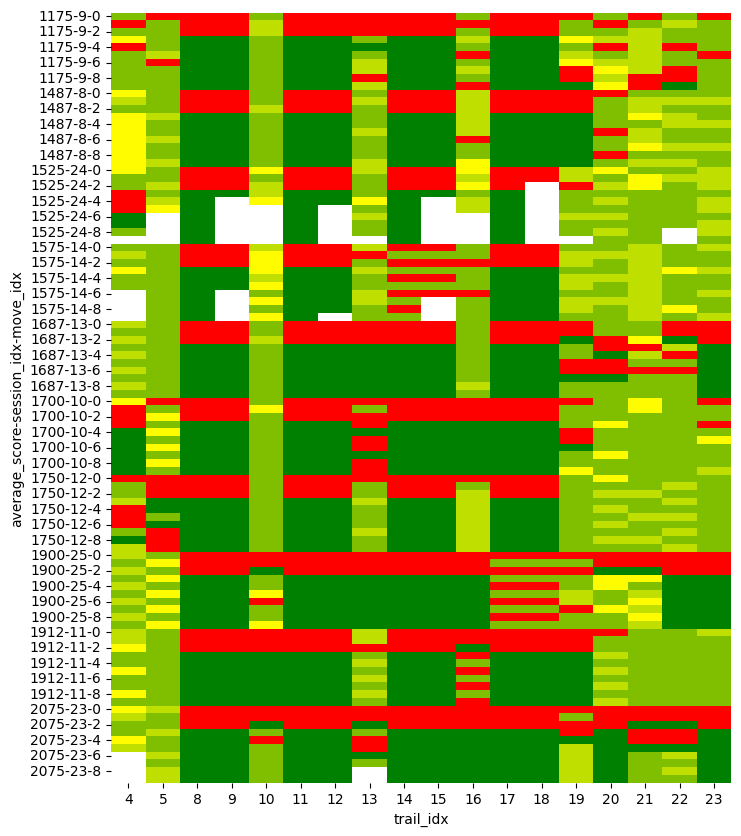

In [36]:
moves_df = moves_df.sort_values(by=['average_score'])

moves_matrix = moves_df.pivot_table(index=['average_score', 'session_idx', 'move_idx'], columns=['trail_idx'], values='reward')
n_sessions = len(moves_matrix.index.levels[0])

# Original nodes and colors
nodes = np.array([-50, 0, 400])
colors = ["red", "yellow", "green"]

# Normalize nodes to be in the range [0, 1]
norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))

plt.figure(figsize=(8, n_sessions))

sns.heatmap(moves_matrix, cmap=cmap, cbar=False)


<Axes: xlabel='trail_idx', ylabel='session_idx'>

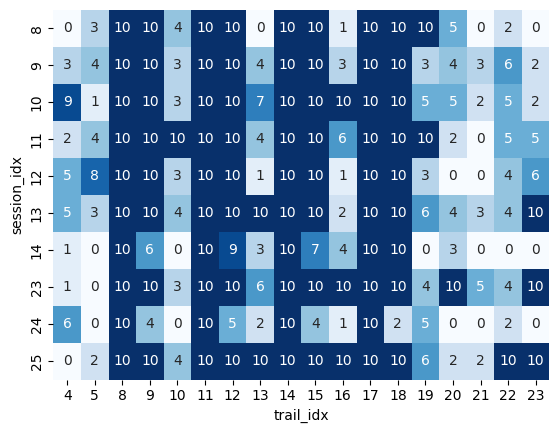

In [37]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trail_idx'], values='optimal', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trail_idx', ylabel='session_idx'>

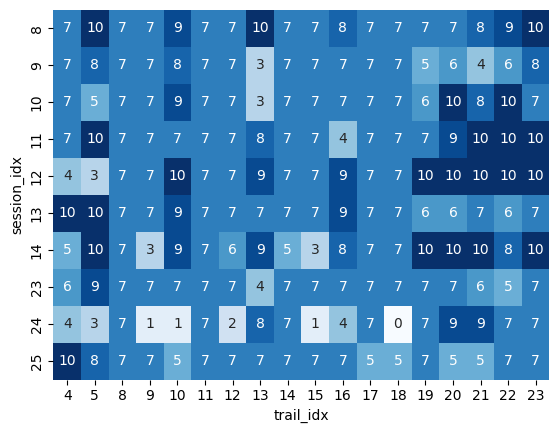

In [38]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trail_idx'], values='myopic', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trail_idx', ylabel='session_idx'>

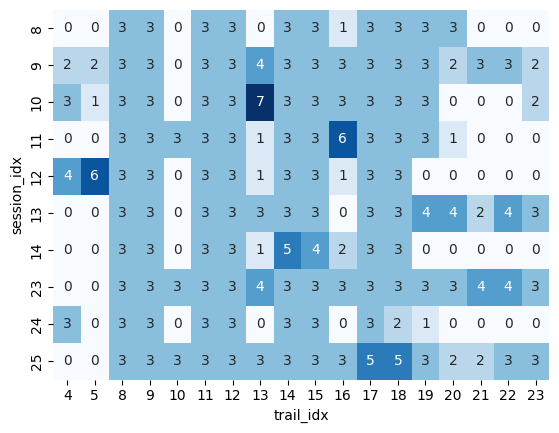

In [39]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trail_idx'], values='large_loss_taken', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


In [40]:
# large_loss_taken, myopic, optimal

moves_behavior = moves_df.melt(id_vars=['session_idx', 'trail_idx'], value_vars=['large_loss_taken', 'myopic', 'optimal'], var_name='behavior', value_name='count')


<Axes: xlabel='trail_idx', ylabel='count'>

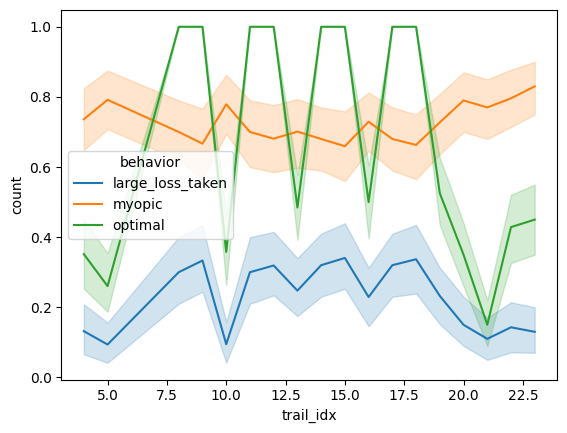

In [41]:
sns.lineplot(data=moves_behavior, x='trail_idx', y='count', hue='behavior')


<Axes: xlabel='trail_idx', ylabel='reward'>

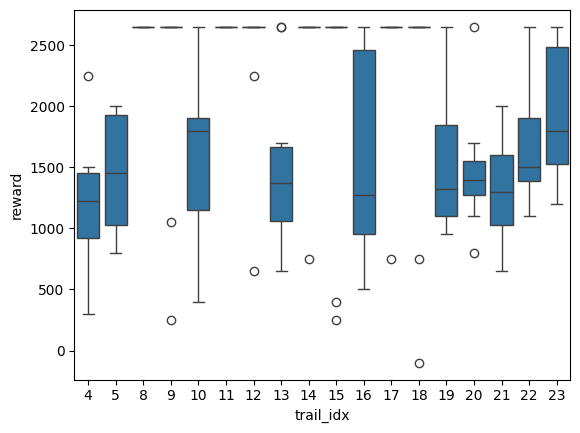

In [42]:
df_group = moves_df.groupby(['session_idx', 'trail_idx'])['reward'].sum().reset_index()

sns.boxplot(data=df_group, x='trail_idx', y='reward')


In [43]:
trails_df[trails_df['trial_type'] == 'written_strategy']['written_strategy'].iloc[0]


{'strategy': '', 'trial_id': None, 'finished_at': None}